# Executive Hour & Energy price forecasting

This notebook contains a selection of the models that were generated during the course of our work on energy price forecasting. The notebook will initialize each model, train it and then score it according to the validation and test data sets. Finally, all models are compared againts the chosen baseline model.  

The target of our project is to predict the day-ahead price (`DA_price`) of electricty in New York city area. The DA price is the price of electricty that is charged at time `t` for delivery of electricty at time `t+24` hours. In contrast to the real-time (`RT`) price, which is for buying and selling electricty on the spot for immediate consumption and is therefore quite volatile, the `DA` price mechanism allows for an element of predictability and stability. 

In our case, we choose a reasonable baseline model: `DA_price` at time `t` is the same as the `DA_price` at time `t-24h`. 

**This notebook is for our multi-step models. That is, the next 24 hours is predicted all at once, with the exception of the ARIMA model.**

### Group Members:
Irem Altiner, Souparna Purohit, Nicolas Fortier, Rouzbeh Yazdi  
Mentor: Julian Rosen

In [1]:
## imports:
## our own models
import rouz_helpers as rhelp
import rouz_model as rmodel ## Rouz's model(s) --> Linear, Deep and CNN models
# import LSTM as nmodel ## Nic's model(s) --> multi-layered LSTM
# import irem_model as imodel ## Irem's model --> ARIMA
# import XGB as smodel ## Souparna's model --> XGBoost regressor model

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, NullLocator
from datetime import datetime

from tensorflow import keras
import tensorflow as tf

In [3]:
## I am running on an M1 Mac machine and for some reason
## running tensorflow with GPU is a __pain__
tf.config.set_visible_devices([], "GPU")

In [4]:
val_performance, performance = {}, {}

## Model Set 1: Baseline, linear, dense and convolutional

Presented here are 4 models.

In [5]:
## Read in the data, remove the first few days
data_frames = rhelp.read_data(loc='../../data_processing/final_data/')
train_df, val_df, test_df, price_mean, price_std, col_indices = rhelp.process_data(*data_frames)

In [6]:
"""
    Only one windowing option here:
        Given 24 hours of inputs (input_width) predict 24 hours into the future
"""
PATIENCE = 10
MAX_EPOCHS = 100

NFEATURES = train_df.shape[1]
OUT_STEPS = 24
CONVWIDTH = 6
BATCH_SIZE= 1024
multi_window = rhelp.WindowGenerator(input_width=24,
                                   label_width=OUT_STEPS,
                                   shift=OUT_STEPS,
                                   batch_size=BATCH_SIZE,
                                   train_df=train_df,
                                   val_df=val_df,
                                   test_df=test_df)

In [7]:
## Models:
baseline_model = rmodel.Baseline("Baseline")
linear_model   = rmodel.LinearMultiStep("Linear", OUT_STEPS, NFEATURES)
dense_model    = rmodel.DenseMultistep("Dense", OUT_STEPS, NFEATURES)
cnn_model      = rmodel.ConvolutionalMultiStep("CNN", CONVWIDTH, OUT_STEPS, NFEATURES)

### Baseline
The first is the baseline where take the next 24 values of day-ahead price to be the previous 24 hours of this observable.

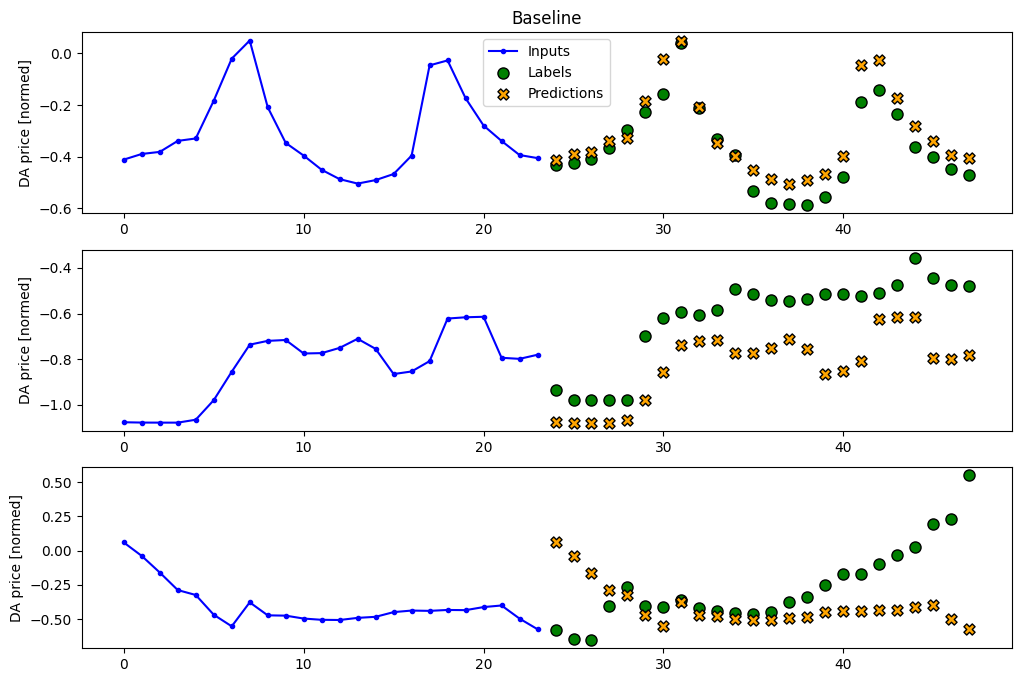

In [8]:
## Now train and test the models
baseline_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.RootMeanSquaredError()])
fig1 = multi_window.plot(baseline_model, colors=['blue','green','orange'], title='Baseline')

### Linear Model:
The model takes in a 24 hour window of data but only considers the last hour. Based on that, a dense layer with linear activation is trained and attempts at a single-shot prediction of the next 24 hours.

In [9]:
history_linear = rmodel.compile_and_fit(linear_model, multi_window, patience=PATIENCE, max_epochs=MAX_EPOCHS)

Epoch 1/100
18/18 [==============================] - 1s 22ms/step - loss: 0.4950 - root_mean_squared_error: 0.7035 - val_loss: 0.6710 - val_root_mean_squared_error: 0.8191
Epoch 2/100
18/18 [==============================] - 0s 19ms/step - loss: 0.2863 - root_mean_squared_error: 0.5350 - val_loss: 0.5865 - val_root_mean_squared_error: 0.7658
Epoch 3/100
18/18 [==============================] - 0s 18ms/step - loss: 0.2289 - root_mean_squared_error: 0.4785 - val_loss: 0.5438 - val_root_mean_squared_error: 0.7374
Epoch 4/100
18/18 [==============================] - 0s 17ms/step - loss: 0.1994 - root_mean_squared_error: 0.4465 - val_loss: 0.5168 - val_root_mean_squared_error: 0.7189
Epoch 5/100
18/18 [==============================] - 0s 19ms/step - loss: 0.1823 - root_mean_squared_error: 0.4270 - val_loss: 0.5009 - val_root_mean_squared_error: 0.7077
Epoch 6/100
18/18 [==============================] - 0s 17ms/step - loss: 0.1715 - root_mean_squared_error: 0.4141 - val_loss: 0.4884 - val_

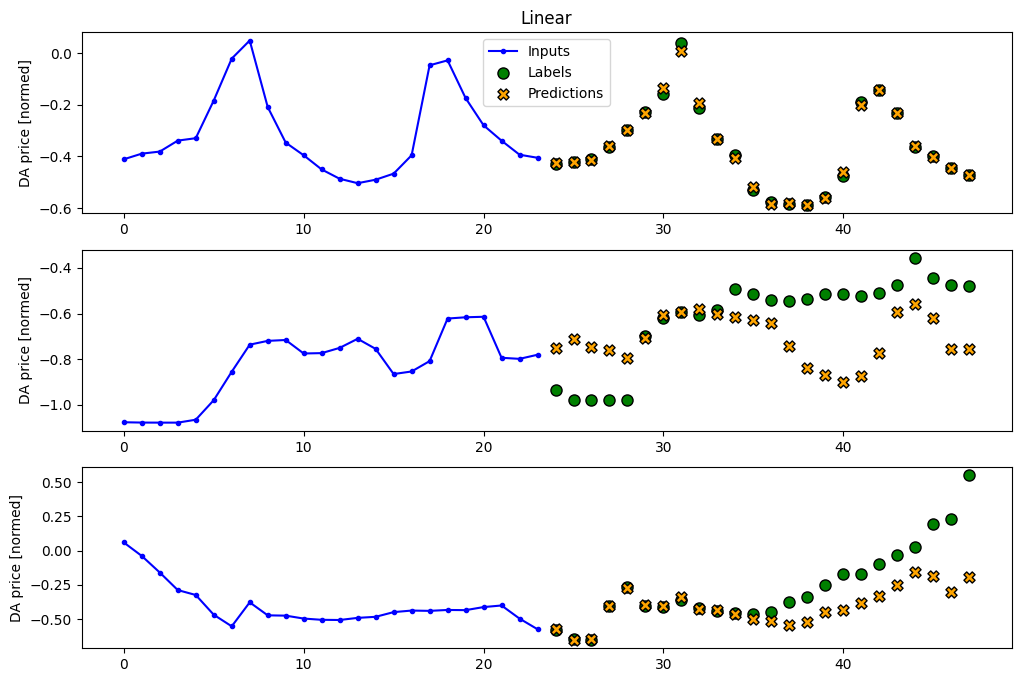

In [10]:
fig2 = multi_window.plot(linear_model, colors=['blue','green','orange'], title='Linear')

### Dense Model:
Similar to the linear model with the exception that before the linear layer, we introduce a dense and fully connected layer with ReLU activation. It will be able to capture more of the complexity of the data.

In [11]:
history_dense = rmodel.compile_and_fit(dense_model, multi_window, patience=PATIENCE, max_epochs=MAX_EPOCHS)

Epoch 1/100
18/18 [==============================] - 1s 28ms/step - loss: 0.4274 - root_mean_squared_error: 0.6537 - val_loss: 0.5731 - val_root_mean_squared_error: 0.7570
Epoch 2/100
18/18 [==============================] - 1s 28ms/step - loss: 0.2031 - root_mean_squared_error: 0.4506 - val_loss: 0.4970 - val_root_mean_squared_error: 0.7050
Epoch 3/100
18/18 [==============================] - 1s 26ms/step - loss: 0.1624 - root_mean_squared_error: 0.4030 - val_loss: 0.4727 - val_root_mean_squared_error: 0.6875
Epoch 4/100
18/18 [==============================] - 1s 21ms/step - loss: 0.1464 - root_mean_squared_error: 0.3827 - val_loss: 0.4573 - val_root_mean_squared_error: 0.6763
Epoch 5/100
18/18 [==============================] - 1s 24ms/step - loss: 0.1381 - root_mean_squared_error: 0.3716 - val_loss: 0.4509 - val_root_mean_squared_error: 0.6715
Epoch 6/100
18/18 [==============================] - 1s 28ms/step - loss: 0.1330 - root_mean_squared_error: 0.3647 - val_loss: 0.4466 - val_

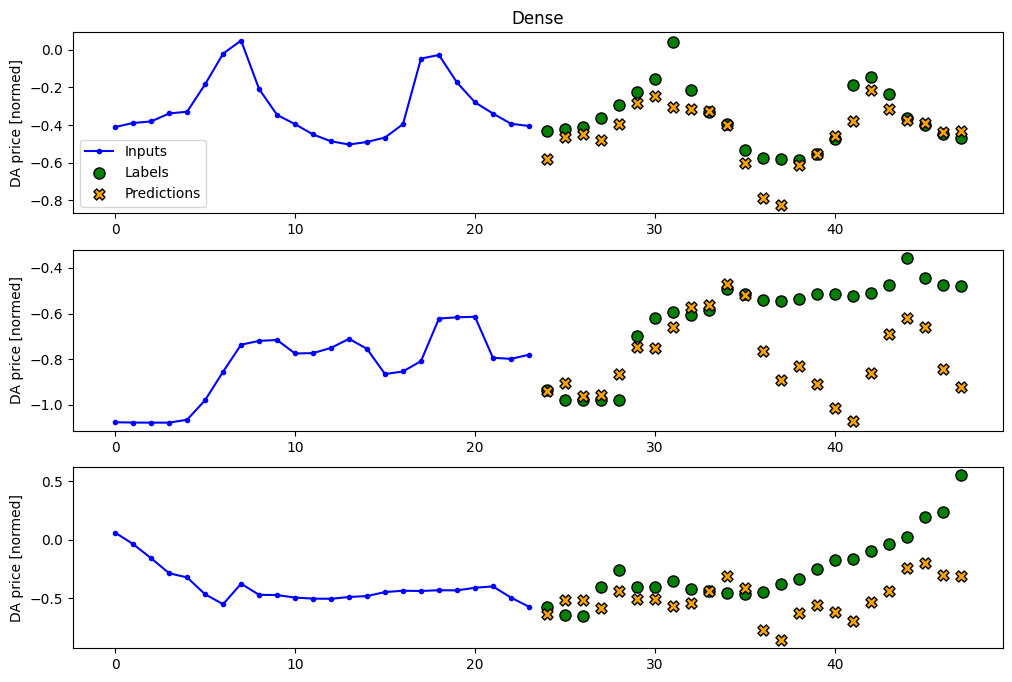

In [12]:
fig3 = multi_window.plot(dense_model, colors=['blue','green','orange'], title='Dense')

### CNN Model
Similar to the previous two but instead of a dense, fully connected layer seeing only the last time step, the model applies a convolutional layer and see as much of the previous time steps as the convolutional width (defined a few cells back) allows. 

In [13]:
history_cnn = rmodel.compile_and_fit(cnn_model, multi_window, patience=PATIENCE, max_epochs=MAX_EPOCHS)

Epoch 1/100
18/18 [==============================] - 1s 33ms/step - loss: 0.5780 - root_mean_squared_error: 0.7603 - val_loss: 0.6488 - val_root_mean_squared_error: 0.8055
Epoch 2/100
18/18 [==============================] - 1s 30ms/step - loss: 0.2397 - root_mean_squared_error: 0.4896 - val_loss: 0.5302 - val_root_mean_squared_error: 0.7282
Epoch 3/100
18/18 [==============================] - 1s 28ms/step - loss: 0.1759 - root_mean_squared_error: 0.4194 - val_loss: 0.5039 - val_root_mean_squared_error: 0.7099
Epoch 4/100
18/18 [==============================] - 1s 29ms/step - loss: 0.1514 - root_mean_squared_error: 0.3891 - val_loss: 0.4828 - val_root_mean_squared_error: 0.6949
Epoch 5/100
18/18 [==============================] - 1s 28ms/step - loss: 0.1386 - root_mean_squared_error: 0.3723 - val_loss: 0.4694 - val_root_mean_squared_error: 0.6852
Epoch 6/100
18/18 [==============================] - 1s 24ms/step - loss: 0.1296 - root_mean_squared_error: 0.3600 - val_loss: 0.4661 - val_

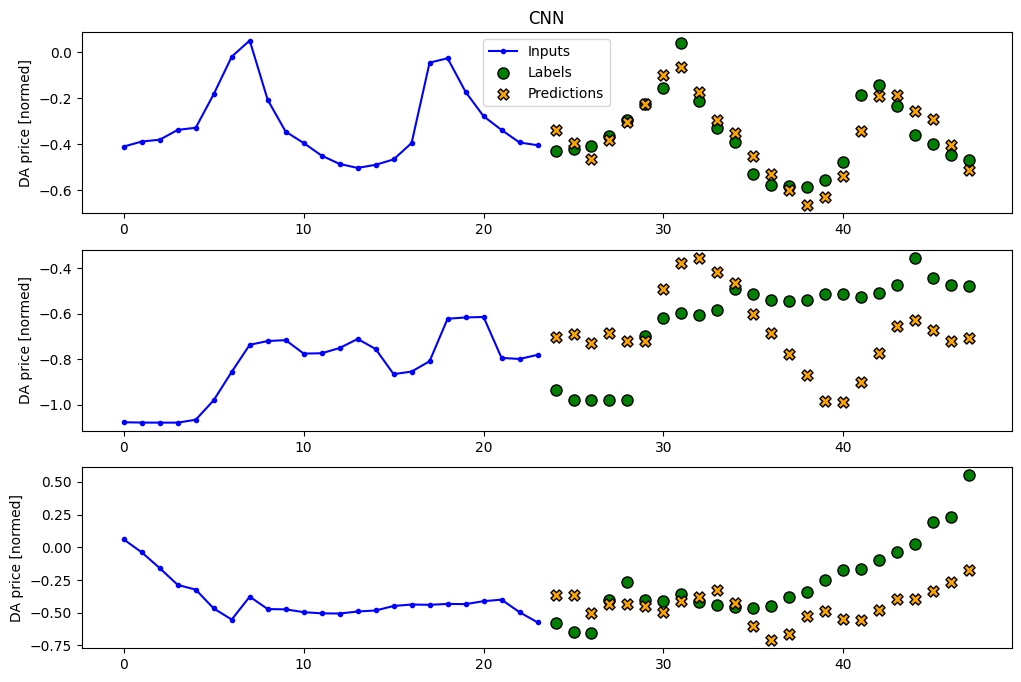

In [14]:
fig4 = multi_window.plot(cnn_model, colors=['blue','green','orange'], title='CNN')

In [15]:
## Compute RMSE for the above 4 models:
for model in [baseline_model, linear_model, dense_model, cnn_model]:
    name = model.name_
    print(f"Dealing with model: {name}")
    rms_err_val = rmodel.get_rmse(model, multi_window.val, 
                           price_mean, price_std,  
                           index=col_indices['DA_price'])
    rms_err_test = rmodel.get_rmse(model, multi_window.test, 
                           price_mean, price_std, 
                           index=col_indices['DA_price'])
    val_performance[name] = rms_err_val
    performance[name]     = rms_err_test

Dealing with model: Baseline
Dealing with model: Linear
Dealing with model: Dense
Dealing with model: CNN


In [16]:
results = pd.DataFrame({'models':val_performance.keys(),
                            'Validation':val_performance.values(),
                            'Test':performance.values()})
results

,models,Validation,Test
0,Baseline,27.587372,26.807522
1,Linear,12.073577,11.354192
2,Dense,12.846262,12.416458
3,CNN,14.055926,13.275033


In [17]:
## Let's first look at what happened during the fits (histories per epoch)

Text(0.02, 0.5, 'Loss Function (MSE)')

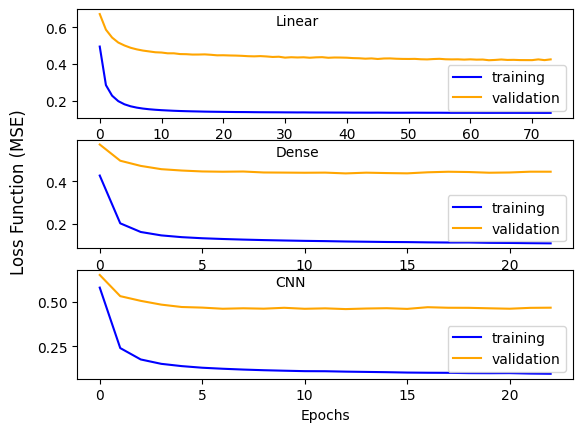

In [18]:
histories = {'Linear':history_linear,
                 'Dense':history_dense, 
                 'CNN': history_cnn}
fig5, axes = plt.subplots(len(histories), 1)
for hist, ax in zip(histories, axes):
    history = histories[hist]
    ax.plot(history.history['loss'], label='training', color='blue')
    ax.plot(history.history['val_loss'], label='validation', color='orange')
    ax.legend(loc='best')
    ax.text(0.4, 0.85, hist,transform=ax.transAxes)
    ax.xaxis.set_minor_locator(NullLocator())
    ax.xaxis.set_minor_formatter(NullFormatter())
axes[-1].set_xlabel('Epochs')
fig5.supylabel('Loss Function (MSE)')

# Scores

Now let's see the scores:

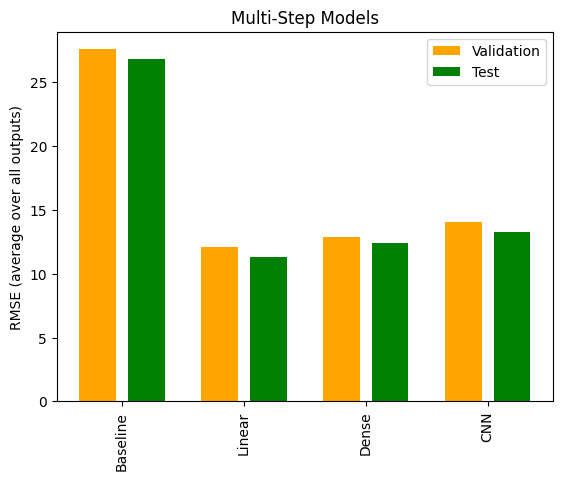

In [19]:
width=0.3
x = np.arange(len(performance))
fig6, ax = plt.subplots(1, 1)
ax.set_title(f"Multi-Step Models")
ax.bar(x - 0.2, results['Validation'].values, width, label="Validation", color='orange')
ax.bar(x + 0.2, results['Test'].values, width, label="Test", color='green')
ax.set_xticks(ticks=x, labels=performance.keys(), rotation=90)
ax.set_ylabel("RMSE (average over all outputs)")
ax.xaxis.set_minor_locator(NullLocator())
ax.xaxis.set_minor_formatter(NullFormatter())
_ = ax.legend()